# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

##Problem Statement

To create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.

The dataset is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: Images/1000268201_693b08cb0e.jpg  
  inflating: Images/1001773457_577c3a7d70.jpg  
  inflating: Images/1002674143_1b742ab4b8.jpg  
  inflating: Images/1003163366_44323f5815.jpg  
  inflating: Images/1007129816_e794419615.jpg  
  inflating: Images/1007320043_627395c3d8.jpg  
  inflating: Images/1009434119_febe49276a.jpg  
  inflating: Images/1012212859_01547e3f17.jpg  
  inflating: Images/1015118661_980735411b.jpg  
  inflating: Images/1015584366_dfcec3c85a.jpg  
  inflating: Images/101654506_8eb26cfb60.jpg  
  inflating: Images/101669240_b2d3e7f17b.jpg  
  inflating: Images/1016887272_03199f49c4.jpg  
  inflating: Images/1019077836_6fc9b15408.jpg  
  inflating: Images/1019604187_d087bf9a5f.jpg  
  inflating: Images/1020651753_06077ec457.jpg  
  inflating: Images/1022454332_6af2c1449a.jpg  
  inflating: Images/1022454428_b6b660a67b.jpg  
  inflating: Images/1022975728_75515238d8.jpg  
  inflating: Images/102351840_323e3de834.jpg  
  inflating: Images/1

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
!pip install gTTs
!pip install playsound
!pip install wordcloud

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=22f2f3fdd3fba60eef9ad9668fbf0628738521814e3121c3964a5d1b600e31d7
  Stored in directory: /home/.cache/pip/wheels/73/cd/cf/9750b618d54bd81c20e4c34fb24a423a5b095920367cdb3f71
Successfully built playsound
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.3/461.3 KB 10.7 MB/s eta 0:00:0000:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
#Import all the required libraries

# tensorflow ml library
import tensorflow as tf

# libraries for data manipulation
import numpy as np
import pandas as pd

import glob
import os
# libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
# library for model build
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# library for bleu score calculation
from nltk.translate.bleu_score import sentence_bleu
#library for image processing
from PIL import Image

#library for text processing
from wordcloud import WordCloud,STOPWORDS

#audio libraries
from gtts import gTTS
from playsound import playsound
from IPython import display

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [ ]:
# directory where dataset exist
DATA_DIR = "/home/dl_content"


In [ ]:
#Import the dataset and read the image into a seperate variable
images = os.path.join(DATA_DIR,'Images')

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


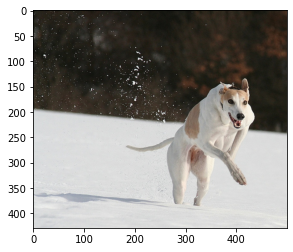

In [ ]:
#Visualise both the images & text present in the dataset
plt.imshow(mpimg.imread(all_imgs[10]))
plt.show()

In [ ]:
#Import the dataset and read the text file into a seperate variable
def load_doc(filename):
    with open(filename,'r') as f:
        text =  list(filter(None, (line.rstrip() for line in f)))
    f.close()
    # extract the text from caption file
    col = [line.split(",",maxsplit=1) for line in text]
    return text

text_file = os.path.join(DATA_DIR,'captions.txt')
# load captions
doc = load_doc(text_file)
print(doc[:300])

['image,caption', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hand

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
#store all the image ids
all_img_id= [i.split(',')[0] for i in doc[1:]]
#store all the image paths
all_img_vector= [os.path.join(images,i.split(',')[0]) for i in doc[1:]]
#store all the captions
annotations= [i.split(',')[1] for i in doc[1:]]

#create the required dataframe
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/home/dl_content/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/home/dl_content/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/home/dl_content/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/home/dl_content/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/home/dl_content/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/home/dl_content/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/home/dl_content/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/home/dl_content/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/home/dl_content/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


As expected, the total dataset has 40455 samples.

In [ ]:
#Create a list which contains all the captions and add the <start> & <end> token to all
annotations = df.Captions.apply(lambda x:'<start> '+ x + ' <end>').to_list()
#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [ ]:
#Create the vocabulary & the counter for the captions
vocabulary= []
for cap in df.Captions.values:
        vocabulary.extend(cap.split())
#Create count of words in vocab
val_count=Counter(vocabulary)
val_count

Counter({'A': 21480,
         'child': 1449,
         'in': 18170,
         'a': 38716,
         'pink': 701,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 1870,
         'entry': 1,
         'way': 48,
         '.': 34205,
         'girl': 3174,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1607,
         'playhouse': 6,
         'the': 14587,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3491,
         'dog': 7804,
         'and': 8057,
         'spotted': 36,
         'are': 3364,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7303,
         'each': 399,
         'other': 666,
         'on': 10354,
         'road': 380,
         'white': 3646,
         'brown': 2383,
         'spots': 28,
         'staring'

In [ ]:
print(f"Size of Vocab : {len(set(vocabulary))}")
print(f"Top Words in Vocab : {val_count.most_common(30)}")

Size of Vocab : 9536
Top Words in Vocab : [('a', 38716), ('.', 34205), ('A', 21480), ('in', 18170), ('the', 14587), ('on', 10354), ('is', 9069), ('and', 8057), ('dog', 7804), ('with', 7303), ('man', 6727), ('of', 6495), ('Two', 3962), ('white', 3646), ('black', 3491), ('boy', 3395), ('are', 3364), ('girl', 3174), ('woman', 3146), ('to', 3005), ('The', 2919), ('wearing', 2916), ('at', 2809), ('water', 2671), ('red', 2542), ('young', 2411), ('people', 2397), ('brown', 2383), ('his', 2255), ('blue', 2116)]


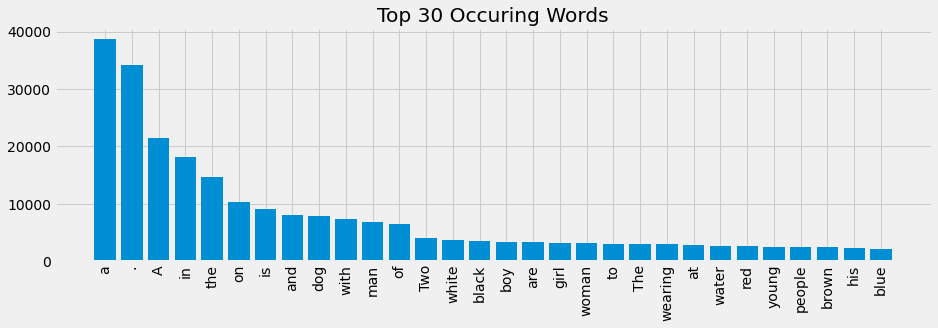

In [ ]:
#Visualise the top 30 occuring words in the captions
def plot_top_words(word_counter):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(14,4))
    plt.xticks(rotation='vertical')
    # extract count of words
    plt.bar(*zip(*word_counter))
    plt.title("Top 30 Occuring Words")
    plt.show()

plot_top_words(val_count.most_common(30))

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
# create the tokenizer

#set vocab count
top_word_count = 5000
#filter out special characters
filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '

# apply keras tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
#convert to tokens
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
#show samples
print(train_seqs[:3])
print(annotations[:3])
# show token for out of vocab words
print(f'OOV Token: {tokenizer.oov_token}')

[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4], [3, 2, 20, 313, 64, 2, 197, 120, 4], [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>']
OOV Token: <unk>


In [ ]:
# Create word-to-index and index-to-word mappings.
word_index = tokenizer.word_index
index_word = tokenizer.index_word
# create mapping for padded tokens as well
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

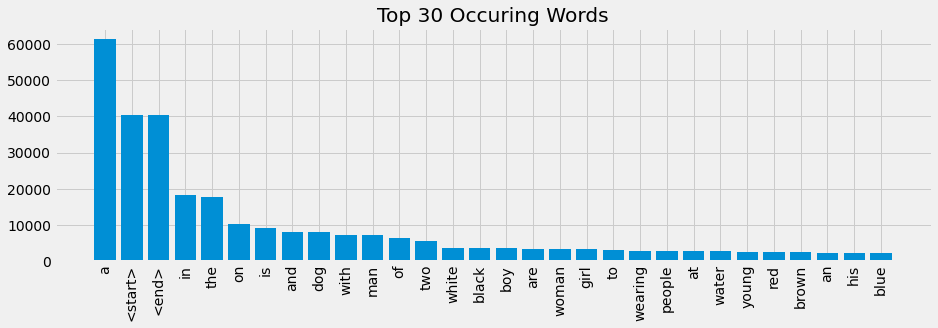

In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda x : x[1], reverse= True)
plot_top_words(sort_word_by_count[:30])

In [ ]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
# get max length
max_sequence_len = max(len(t) for t in train_seqs)
print(f'Max Sequence Length of the Texts is: {max_sequence_len}')
# apply keras padding
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sequence_len)
#shape of Caption vector
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max Sequence Length of the Texts is: 35
The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [ ]:
#Create the dataset consisting of image paths. Function returns images & their path
def load_image(image_path):
    #read file
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # resize to required shape
    img = tf.image.resize(img, (299, 299))
    # apply preprocess of inception 3 module
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# show shape before and after preprocessing
print(f'Size of image before preprocessing: {mpimg.imread(all_img_vector[0]).shape}')
print(f'Size of image after preprocessing: {load_image(all_img_vector[0])[0].shape}')

Size of image before preprocessing: (500, 375, 3)
Size of image after preprocessing: (299, 299, 3)


2023-08-19 12:48:45.713366: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-19 12:48:45.713442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14796 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [ ]:
#Applying the function to the image path dataset, such that the transformed dataset should contain images & their path
unique_img_vector = sorted (set(all_img_vector))
# get tensor slices
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_vector)
# apply fuction and set prefetch and batch size
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
image_dataset


<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



InceptionV3 model is used.Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.

In [ ]:
#load pretrained model
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
#get the input of the image_model
new_input = image_model.input
#get the output of the image_model
hidden_layer = image_model.layers[-1].output
#build the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 6s 0us/step


In [ ]:
#show model summary
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

We are not classifying the images as we only need to extract a feature vector for our images.Hence we are removing the softmax layer from the model. The shape of the output of this layer is 8x8x2048. Then we squeezed that to a shape of (64, 2048).

In [ ]:
# Apply the feature_extraction model to the created dataset which contained images & their respective paths
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  #reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  #store features using numpy(np.save) to store the resulting vector.
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [00:33<00:00,  3.76it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
#Apply train_test_split on both image path & captions to create the train & test list
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42) #your code goes here)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [ ]:
# Create a function which maps the image path to their feature.
def map_func(image, caption):
  img_tensor = np.load(image.decode('utf-8')+'.npy')
  return img_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [ ]:
# Builder function to create dataset which takes in the image path & captions as input
# It transforms the created dataset(img_path,cap) to (features,cap) using the map_func fucntion

def gen_dataset(image, caption,batch_size = 32,buffer_size=1000):
    # create tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    #Set pretech
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [ ]:
#set batch size
BATCH_SIZE =64
#create train and test datasets
train_dataset=gen_dataset(path_train,cap_train,BATCH_SIZE)
test_dataset=gen_dataset(path_test,cap_test,BATCH_SIZE)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
#(batch_size, 8*8, 2048)
print(sample_img_batch.shape)
#(batch_size,max_len)
print(sample_cap_batch.shape)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder


The feature vector is given as input to CNN Encoder which had a single fully connected layer. The output from the encoder, hidden state(initialized to 0), and start token is passed as input to the decoder.

The decoder (RNN ie GRU) attends over the image to predict the next word. We used the attention model to make our decoder focus on a particular part of the image at a time rather than focusing on the entire image. This also reduces noise and improves accuracy.The decoder returns the predicted caption and the decoder's hidden state as output. which is sent back to the model and the predictions are used to calculate the loss using cross-entropy "SparseCategoricalCrossentropy".We also used teacher forcing to decide the next input to the decoder.
The decoder stop predicting when the model predicts the end token.



In [ ]:
#set embedding dimension
embedding_dim = 256
units = 512
#top 5,000 words +1
vocab_size = 5001
#set train and test steps
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [ ]:
#create encoder class by subclass method
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim)

    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features)
        #add relu activation
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
#create encoder class by subclass method
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        #build your Dense layers
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        #build your final Dense layer with unit 1
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = self.V(attention_hidden_layer)
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights =  tf.nn.softmax(score,axis=1)
        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

### Decoder

In [ ]:
#create decoder class by subclass method
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        #iniitalise Attention model with units
        self.attention = Attention_model(self.units)
        #build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # initialise GRU layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        #build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        #build your Dense layer with vocab dimension
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):
        #create context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed input to shape: (batch_size, 1, embedding_dim)
        embed =  self.embed(x)
        # Concatenate input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)
        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
#create decoder instance
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
#get features encoded
features=encoder(sample_img_batch)
#initialise hidden state in decoder
hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
#get decoder outputs
predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
#(batch, 8*8, embed_dim)
print('Feature shape from Encoder: {}'.format(features.shape))
#(batch,vocab_size)
print('Predcitions shape from Decoder: {}'.format(predictions.shape))
#(batch, 8*8, embed_dim)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

Since we padded the text,so we will use masking while loss calculation.
For training,we will use teacher enforcing.

In [ ]:
#define the optimizer as Adam
optimizer = tf.keras.optimizers.Adam()
#define your loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
#create loss fn
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    #apply mask in loss fn
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = os.path.join("checkpoints","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #Provide initial inputs
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
    #Do the training steps
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            #get decoder output
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            #calculate loss
            loss += loss_function(target[:,i], predictions)
            predicted_id = tf.argmax(predictions,1)
            dec_input = tf.expand_dims(predicted_id, 1)
    #get average loss
    avg_loss = (loss / int(target.shape[1]))
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    #get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss,t_loss = test_step(img_tensor,target)
        total_loss += t_loss
    avg_test_loss = total_loss/test_num_steps
    return avg_test_loss

In [ ]:
import time
loss_plot = []
test_loss_plot = []
# set noof epochs
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    # start training
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
    #calculate losses
    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [02:41<37:44, 161.78s/it]

For epoch: 1, the train loss is 1.351, & test loss is 1.999
Time taken for 1 epoch 161.59155702590942 sec

Test loss has been reduced from 100.000 to 1.999


 13%|█▎        | 2/15 [03:35<21:15, 98.15s/it] 

For epoch: 2, the train loss is 1.049, & test loss is 2.004
Time taken for 1 epoch 53.60555291175842 sec



 20%|██        | 3/15 [04:28<15:30, 77.54s/it]

For epoch: 3, the train loss is 0.952, & test loss is 2.032
Time taken for 1 epoch 53.008307456970215 sec



 27%|██▋       | 4/15 [05:20<12:24, 67.65s/it]

For epoch: 4, the train loss is 0.886, & test loss is 2.079
Time taken for 1 epoch 52.48449492454529 sec



 33%|███▎      | 5/15 [06:13<10:22, 62.24s/it]

For epoch: 5, the train loss is 0.831, & test loss is 2.095
Time taken for 1 epoch 52.66197943687439 sec



 40%|████      | 6/15 [07:07<08:55, 59.45s/it]

For epoch: 6, the train loss is 0.782, & test loss is 2.114
Time taken for 1 epoch 54.020474433898926 sec



 47%|████▋     | 7/15 [08:00<07:39, 57.48s/it]

For epoch: 7, the train loss is 0.737, & test loss is 2.136
Time taken for 1 epoch 53.41567826271057 sec



 53%|█████▎    | 8/15 [08:53<06:31, 55.98s/it]

For epoch: 8, the train loss is 0.696, & test loss is 2.218
Time taken for 1 epoch 52.779502153396606 sec



 60%|██████    | 9/15 [09:47<05:31, 55.29s/it]

For epoch: 9, the train loss is 0.658, & test loss is 2.271
Time taken for 1 epoch 53.76491141319275 sec



 67%|██████▋   | 10/15 [10:42<04:35, 55.04s/it]

For epoch: 10, the train loss is 0.622, & test loss is 2.301
Time taken for 1 epoch 54.49272632598877 sec



 73%|███████▎  | 11/15 [11:35<03:38, 54.58s/it]

For epoch: 11, the train loss is 0.590, & test loss is 2.421
Time taken for 1 epoch 53.51913785934448 sec



 80%|████████  | 12/15 [12:27<02:41, 53.93s/it]

For epoch: 12, the train loss is 0.558, & test loss is 2.483
Time taken for 1 epoch 52.43332624435425 sec



 87%|████████▋ | 13/15 [13:20<01:47, 53.64s/it]

For epoch: 13, the train loss is 0.528, & test loss is 2.548
Time taken for 1 epoch 52.983433961868286 sec



 93%|█████████▎| 14/15 [14:14<00:53, 53.52s/it]

For epoch: 14, the train loss is 0.501, & test loss is 2.653
Time taken for 1 epoch 53.22514057159424 sec



100%|██████████| 15/15 [15:07<00:00, 60.47s/it]

For epoch: 15, the train loss is 0.477, & test loss is 2.760
Time taken for 1 epoch 52.81729793548584 sec



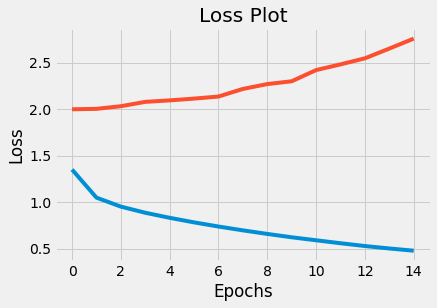

In [ ]:
#plot train and test losses
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

The prediction of the words by the model is done by finding out the probabilities of that word in the vocabulary. We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

Finally, we are using the "BLEU score"(Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption

### Greedy Search

In [ ]:
attention_features_shape = 64
def evaluate(image):
    #initilaise decoder
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))
    hidden = decoder.init_state(batch_size=1)
    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_sequence_len):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
# set beam index
#evaluate the result using beam search
def beam_evaluate(image, beam_index =3):
    #set initial token and decoder state
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))
    hidden = decoder.init_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # get encoded features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_sequence_len:
        temp = []
        for i, s in enumerate(result):
            #get decoder output
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                #find probabilities
                prob += np.log(predictions[0][w])
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda x: x[1])
        result = result[-beam_index:]

        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break

    result2 = result[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption



two dogs in the field


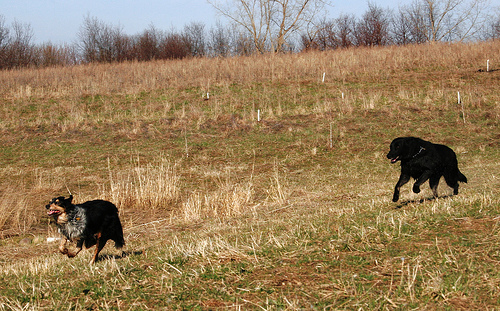

In [ ]:
#optional beam
test_image = path_test[25]
# get caption using beam search
captions=beam_evaluate(test_image)
print(captions)
Image.open(test_image)

##Prediction with test data

In [ ]:
# function to plot attention map
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        #reshape
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        #plot attention map
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        img=ax.imshow(temp_img)
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
#filter the caption
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    # remove uncessary tokens
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

We will use n_grams(1,2) evaluate the predicted caption. This is beacuse this is not a state of art model, thus making poor prediction higher n grams(3,4).Hence Bleu weights set to (0.5,0.25,0,0).

In [ ]:
# function to generate caption
def test_caption_generation(img_test):
    # get random image from test set
    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    #process real caption
    real_caption = ' '.join(tokenizer.index_word[i] for i in cap_test[rid] if i not in [0])
    real_caption=filt_text(real_caption)
    #generate predicted caption
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    # compare prediction with ground truth
    real_appn = [real_caption.split()]
    reference = real_appn
    candidate = pred_caption.split()
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)

    # get bleu score for prediction
    score = sentence_bleu(reference, candidate, weights=(0.5,0.25,0,0))
    print(f"BELU score: {score*100}")


    # use Google Text to Speech Online API from playing the predicted caption as audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False)
    speech.save('audio.mp3')
    audio_file = 'audio.mp3'
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=False))

    #return the test image and attention plot
    return result, attention_plot,test_image


Real Caption: two people having a picnic by the shore
Prediction Caption: two people talking on a lake
BELU score: 33.88267372816049


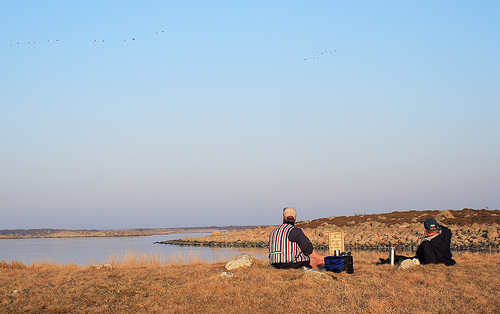

In [ ]:
result, attention_plot,test_image = test_caption_generation(path_test)

Image.open(test_image)

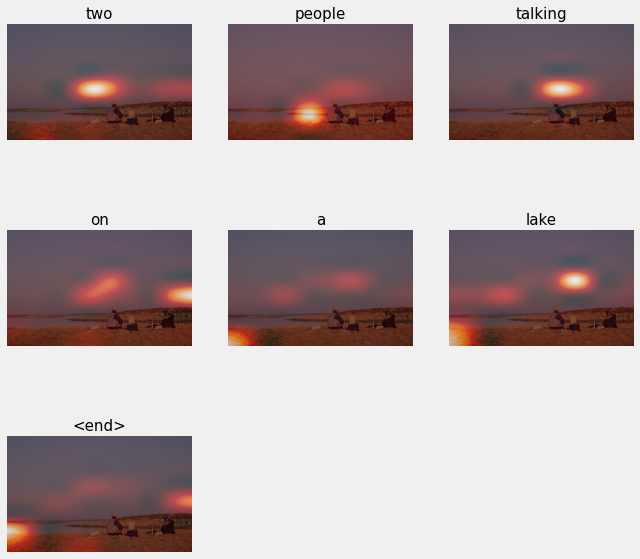

In [ ]:
#plot attention map generated
plot_attmap(result, attention_plot, test_image)